In [1]:
import os
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dlutils.morpho import Tree
from dlutils.graphics import plot_tree

%matplotlib inline

In [2]:
def worker(section_num, segment_x, cell_type, cell, optimization_run, individual):
    impedance_data_file = base_folder + '/' + cell_type.capitalize() + '/' + cell + '/' + optimization_run + \
        '_' + cell + '_/impedance_experiment/with_voltage_traces/' + cell + '_impedance_individual_' + \
        str(individual) + '_active.pkl'
    amplitude_ratio_folder = base_folder + '/' + cell_type.capitalize() + '/' + cell + '/' + optimization_run + \
        '_' + cell + '_/amplitude_ratio_experiment/with_voltage_traces/'
    impedance_data = pickle.load(open(impedance_data_file, 'rb'))

    swc_file = glob.glob(base_folder + '/' + cell_type.capitalize() + '/' + \
                         cell + '/' + optimization_run + '_' + cell + '_/*.swc')[0]
    tree = Tree(swc_file)

    t = {k: {} for k in ('Z','AR')}
    Vm = {k: {} for k in ('Z','AR')}
    for k,v in section_num.items():
        segment_num = segment_map[cell_type][k][v][segment_x[k]]
        t['Z'][k] = impedance_data['time'][k][segment_num]
        Vm['Z'][k] = impedance_data['Vm'][k][segment_num]
        
    AR_data = {}
    for k,v in section_num.items():
        pkl_file = f'{amplitude_ratio_folder}AR_individual_{individual}_{k}[{v}]({segment_x[k]})' + \
            '_TTX_Ra=1x_dV=10.0.pkl'
        if os.path.isfile(pkl_file):
            AR_data[k] = pickle.load(open(pkl_file, 'rb'))
            t['AR'][k] = AR_data[k]['time']
            Vm['AR'][k] = np.array([AR_data[k]['Vspine'], AR_data[k]['Vdend'], AR_data[k]['Vsoma']])
            
    df = {}
    for loc in 'soma','basal','apical':
        sec = section_num[loc]
        x = segment_x[loc]
        segment_num = segment_map[cell_type][loc][sec][x]
        key = f'impedance_{loc}_{segment_num}'
        center = impedance_data['centers'][loc][segment_num]
        df1 = pd.DataFrame(data = {'x': [center[0]], 'y': [center[1]], 'z': [center[2]],
                                   'impedance': [impedance_data['R'][loc][segment_num]]})
        df2 = pd.DataFrame(data = {'Time': t['Z'][loc], 'Vm': Vm['Z'][loc]})
        df[key] = pd.concat([df1,df2], ignore_index=True, axis=1)
        df[key].columns = ('x', 'y', 'z', 'impedance', 'Time', 'Vm')

    for loc in 'basal','apical':
        sec = section_num[loc]
        x = segment_x[loc]
        segment_num = segment_map[cell_type][loc][sec][x]
        key = f'amplitude_ratio_{loc}_{segment_num}'
        center = AR_data[loc]['dend_center']
        df1 = pd.DataFrame(data = {'x': [center[0]], 'y': [center[1]], 'z': [center[2]],
                                    'dendrite_impedance': [AR_data[loc]['R_dend']],
                                    'neck_impedance': [AR_data[loc]['R_neck']],
                                    'amplitude_ratio': [AR_data[loc]['AR']]})
        df2 = pd.DataFrame(data = {'Time': t['AR'][loc], 'Vspine': Vm['AR'][loc][0,:],
                                   'Vdend': Vm['AR'][loc][1,:], 'Vsoma': Vm['AR'][loc][2,:]})
        df[key] = pd.concat([df1,df2], ignore_index=True, axis=1)
        df[key].columns = ('x', 'y', 'z', 'dendrite_impedance', 'neck_impedance', 'amplitude_ratio',
                           'Time', 'Vspine', 'Vdend', 'Vsoma')
    xls_file = f'{base_folder}{cell_type.capitalize()}/{cell}/{optimization_run}_{cell}_/' + \
        f'impedance_amplitude_ratio_voltage_traces_{cell_type}.xlsx'
    with pd.ExcelWriter(xls_file) as writer:
        for key in df:
            df[key].to_excel(writer, sheet_name=key, index=False)
            
            
    t0 = {'Z': 500, 'AR': 150}
    height = 3
    fig = plt.figure(figsize=(height * tree.xy_ratio * 3, height))
    gs = fig.add_gridspec(2, 2)
    ax = [
        fig.add_subplot(gs[0,1:]),
        fig.add_subplot(gs[1,1:]),
        fig.add_subplot(gs[:,0])
    ]
    color = {'soma': [0,0,0], 'apical': [0,.7,0], 'basal': [.7,0,.7]}
    for loc in section_num.keys():
        ax[0].plot(t['Z'][loc] - t0['Z'], Vm['Z'][loc], color=color[loc], lw=1, label=loc.capitalize())
        if loc != 'soma':
            ax[1].plot(t['AR'][loc] - t0['AR'], Vm['AR'][loc][0,:], color=color[loc], lw=1)
            ax[1].plot(t['AR'][loc] - t0['AR'], Vm['AR'][loc][1,:], '--', color=color[loc], lw=1)
            center = AR_data[loc]['dend_center']
            ax[-1].plot(center[0], center[1], 'o', ms=3.5, color=color[loc])
    for a in ax:
        for side in 'right','top':
            a.spines[side].set_visible(False)
        if a != ax[-1]:
            a.set_ylabel('Vm (mV)')
    ax[0].set_xlim([-50, 600])
    ax[1].set_xlim([-25, 100])
    #ax[0].legend(loc='lower right')
    ax[1].set_xlabel('Time (ms)')

    plot_tree(tree, type_ids=(1,3,4), scalebar_length=200, ax=ax[-1])
    ax[-1].axis('off')

    fig.tight_layout()
    pdf_file = f'{base_folder}{cell_type.capitalize()}/{cell}/{optimization_run}_{cell}_/' + \
        f'impedance_amplitude_ratio_voltage_traces_{cell_type}.pdf'
    fig.savefig(pdf_file)

In [3]:
segment_map = {
    'a-thorny': {
        'soma': {0: {0.5: 0}},
        'apical': {
            16: {
                0.2: 127,
                0.5: 133
            }
        },
        'basal': {
            19: {
                0.2: 80,
                0.5: 83
            }
        }
    },
    'thorny': {
        'soma': {0: {0.5: 0}},
        'apical': {
            14: {
                0.2: 38,
                0.5: 44
            }
        },
        'basal': {
            80: {
                0.2: 307,
                0.5: 309
            }
        }
    }
}

base_folder = '/Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/'

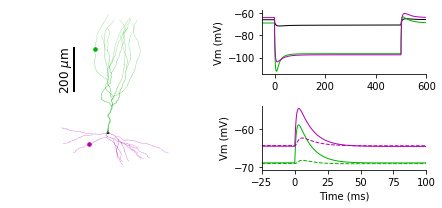

In [4]:
cell_type = 'a-thorny'
cell = 'DH070213C3'
individual = 0
optimization_run = '20191206232623'
section_num = {'soma': 0, 'apical': 16, 'basal': 19}
segment_x = {'soma': 0.5, 'apical': 0.5, 'basal': 0.5}
worker(section_num, segment_x, cell_type, cell, optimization_run, individual)

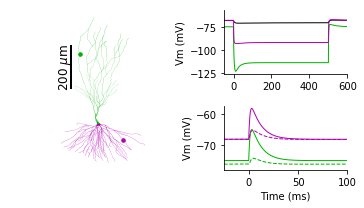

In [5]:
cell_type = 'thorny'
cell = 'DH070813'
individual = 1
optimization_run = '20191208071008'
section_num = {'soma': 0, 'apical': 14, 'basal': 80}
segment_x = {'soma': 0.5, 'apical': 0.5, 'basal': 0.5}
worker(section_num, segment_x, cell_type, cell, optimization_run, individual)